In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras import layers
from keras import models
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from keras.models import load_model

import os #システム操作系
from pathlib import Path #ファイル操作系

from scipy.optimize import curve_fit    # フィッティング用

import datetime
import time

import pandas as pd
import pickle

dt_now = datetime.datetime.now()
print('現在時刻：', dt_now)

Using TensorFlow backend.


現在時刻： 2021-01-11 01:33:18.785545


In [25]:
# このファイルの存在するフォルダの絶対パスを取得
dir_name = str(Path().resolve())
print('このファイルの存在するフォルダ：', dir_name)
# 保存先フォルダのパス作成
save_folder = os.path.join(dir_name, f'210105')
print('保存フォルダ：', save_folder)
# 保存先フォルダの作成(既に存在する場合は無視される)
os.makedirs(save_folder, exist_ok=True)

このファイルの存在するフォルダ： /Users/nagaiyuma/Documents/myprogram
保存フォルダ： /Users/nagaiyuma/Documents/myprogram/210105


In [3]:
# グラフの初期設定
plt.rcParams["figure.figsize"] = [3.14, 3.14] # 図の縦横のサイズ([横(inch),縦(inch)])
plt.rcParams["figure.dpi"] = 200 # dpi(dots per inch)
plt.rcParams["figure.facecolor"] = 'white' # 図の背景色
plt.rcParams["figure.edgecolor"] = 'black' # 枠線の色
plt.rcParams["font.family"] = "serif"       # 使用するフォント
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 14              # 基本となるフォントの大きさ
plt.rcParams["xtick.direction"] = "in"      # 目盛り線の向き、内側"in"か外側"out"かその両方"inout"か
plt.rcParams["ytick.direction"] = "in"      # 目盛り線の向き、内側"in"か外側"out"かその両方"inout"か
plt.rcParams["xtick.bottom"] = True         # 下部に目盛り線を描くかどうか
plt.rcParams["ytick.left"] = True           # 左部に目盛り線を描くかどうか
plt.rcParams["xtick.major.size"] = 2.0      # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 2.0      # y軸主目盛り線の長さ
plt.rcParams["xtick.major.width"] = 0.3     # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 0.3     # y軸主目盛り線の線幅
plt.rcParams["xtick.minor.visible"] = False # x軸副目盛り線を描くかどうか
plt.rcParams["ytick.minor.visible"] = False # y軸副目盛り線を描くかどうか
plt.rcParams["xtick.minor.size"] = 2.0      # x軸副目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 2.0      # y軸副目盛り線の長さ
plt.rcParams["xtick.minor.width"] = 0.3     # x軸副目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 0.3     # y軸副目盛り線の線幅
plt.rcParams["xtick.labelsize"] = 8        # 目盛りのフォントサイズ
plt.rcParams["ytick.labelsize"] = 8        # 目盛りのフォントサイズ
plt.rcParams["xtick.major.pad"] = 3.0      # x軸から目盛までの距離
plt.rcParams["ytick.major.pad"] = 4.0      # y軸から目盛までの距離
plt.rcParams["axes.labelsize"] = 10         # 軸ラベルのフォントサイズ
plt.rcParams["axes.linewidth"] = 0.4        # グラフ囲う線の太さ
plt.rcParams["axes.grid"] = False           # グリッドを表示するかどうか

In [ ]:
#フィッティングパラメータ取得
data_param_path = '2020-12-12_16-27_fit-param.pkl'
with open(data_param_path, mode="rb") as f:
    param = pickle.load(f)
print(param)

In [3]:
#フィッティングパラメータ取得
data_param_path = '2021-01-07_14-08_fit-param.pkl'
with open(data_param_path, mode="rb") as f:
    param = pickle.load(f)
print(param)

[9.84754616e-01 9.97140288e+01 4.55644713e+01 9.99275241e-03]


In [ ]:
#データ取得
time = '2021-01-08_15-17'
data_param_path = time + 'train_x.pkl'
with open(data_param_path, mode="rb") as f:
    train_x = pickle.load(f)
print(train_x.shape)
data_param_path =  time + 'train_x2.pkl'
with open(data_param_path, mode="rb") as f:
    train_x2 = pickle.load(f)
print(train_x2.shape)
data_param_path = time + 'train_t.pkl'
with open(data_param_path, mode="rb") as f:
    train_t = pickle.load(f)
print(train_t.shape)
data_param_path = time + 'test_x.pkl'
with open(data_param_path, mode="rb") as f:
    test_x = pickle.load(f)
print(test_x.shape)
data_param_path = time + 'test_x2.pkl'
with open(data_param_path, mode="rb") as f:
    test_x2 = pickle.load(f)
print(test_x2.shape)
data_param_path = time + 'test_t.pkl'
with open(data_param_path, mode="rb") as f:
    test_t = pickle.load(f)
print(test_t.shape)

print(test_t.T[2])
print(test_t.T[3])

In [15]:
train_num = 21000 #訓練データの数
test_num = 2100 #テストデータの数
data_size = 200 #配列の大きさ

train_x = np.zeros((train_num,data_size,data_size))
train_t = np.zeros((len(param),train_num))
test_x = np.zeros((test_num,data_size,data_size))
test_t = np.zeros((len(param),test_num))

train_x2 = np.zeros((train_num,data_size,data_size))
test_x2 = np.zeros((test_num,data_size,data_size))

In [16]:
#訓練データ作成
N = train_num #訓練データの個数
#1Dガウシアンビームの関数の定義
def gaussian_beam(x,i0,x0,w0,h0):
    return  i0 * np.exp(-2*(x-x0)**2/w0**2) + h0


#中心位置
idx = np.arange(0.0, 21, 1).repeat(N/21)
print(idx)
train_t[0] = param[0].repeat(N)
train_t[1] = idx
train_t[2] = param[2].repeat(N)
train_t[3] = param[3].repeat(N)
train_t = train_t.T
idx = idx-10.0
print(idx)
#画像サイズ
size = 100
x_array = np.arange(0, size*2, 1.0)                         # x配列
y_array = np.arange(0, size*2, 1.0)                         # y配列
nx = len(x_array)
intensity = np.zeros((N,nx))
idx = idx + size #中心に持ってくる
print(idx)

[ 0.  0.  0. ... 20. 20. 20.]
[-10. -10. -10. ...  10.  10.  10.]
[ 90.  90.  90. ... 110. 110. 110.]


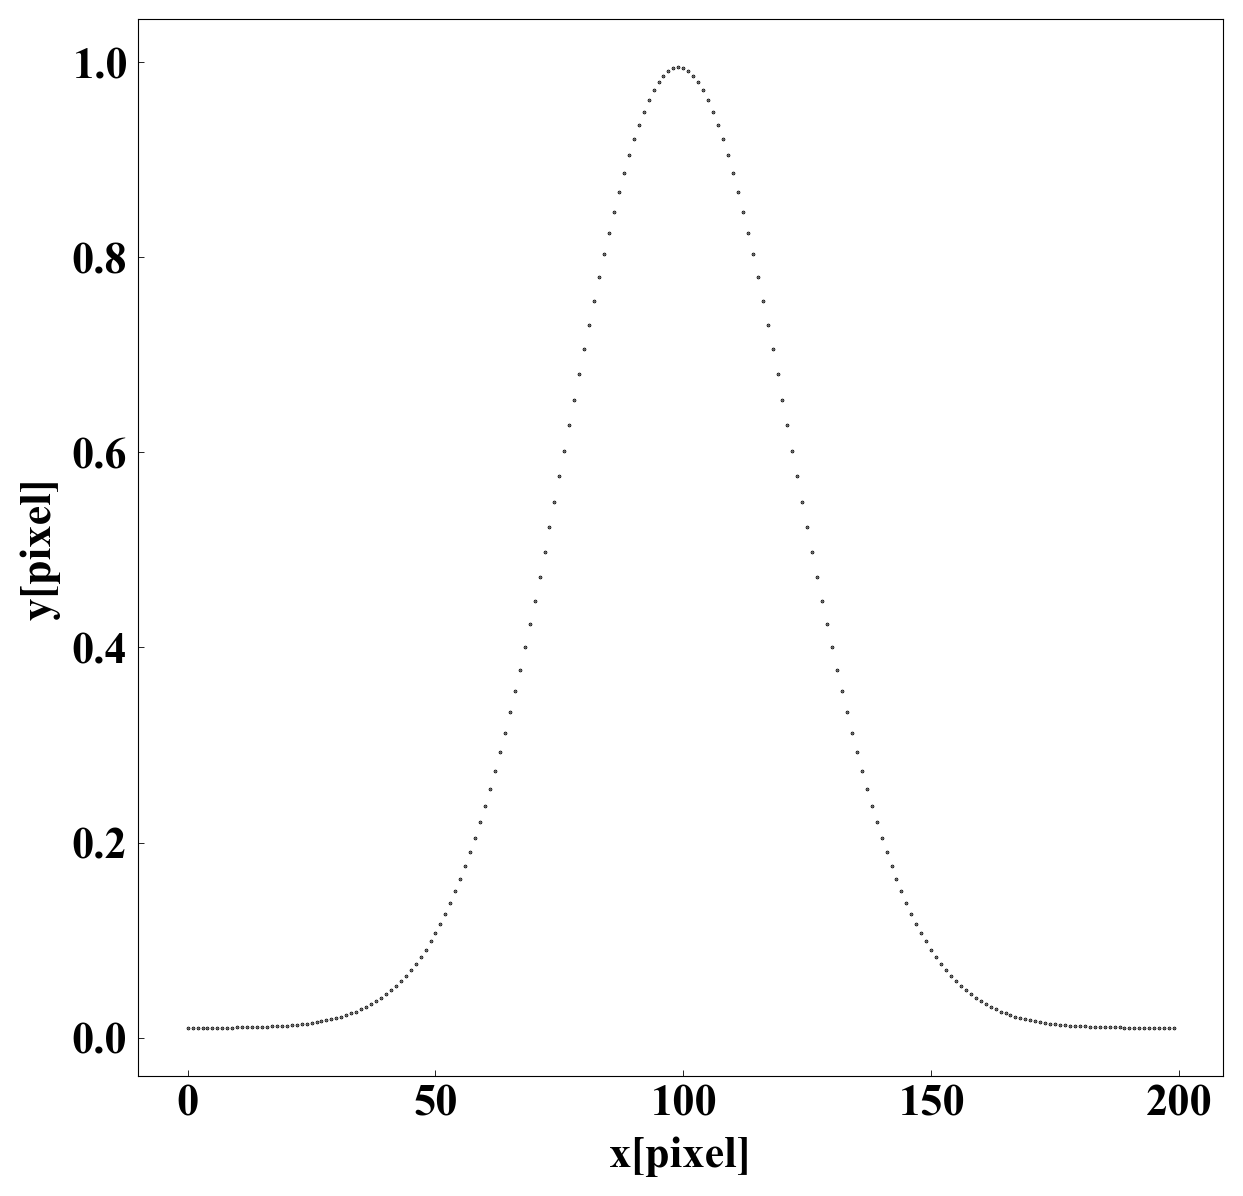

In [9]:
start = time.time()
for n in range(N):
    #初期パラメータ
    i0 = param[0]
    x0 = idx[n]
    w0 = param[2]
    h0 = param[3]
    param = np.array([i0,x0,w0,h0])  #初期値
    
    #強度の計算
    intensity[n] = gaussian_beam(x_array, *param)

save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +'_gauss.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_xlabel("x[pixel]", fontsize=16)
ax.set_ylabel("y[pixel]", fontsize=16)
plt.tick_params(labelsize=16)
ax.grid(False)
ax.scatter(x_array, intensity[0], color='black', s=0.1)
#fig.savefig(save_file, format="png", bbox_inches="tight")
plt.show()

In [13]:
intensity_noise = np.zeros((N, nx))
intensity_noise2 = np.zeros((N, nx))
NOISE = np.zeros((N, nx))
noise = np.zeros((N, nx))

for i in range(21):
    profile_i = intensity[int(i*N/21)].flatten()
    print(idx[int(i*N/21)])
    for k in range(nx):
        NOISE[int(i*N/21):int((i+1)*N/21),k] = (np.random.normal(loc=0,scale=0.00844*profile_i[k]+0.00165,size=int(N/21)))
        noise[int(i*N/21):int((i+1)*N/21),k] = (np.random.rand(int(N/21))-0.5)*10*0.01
NOISE = NOISE.reshape(N,nx)
intensity_noise = intensity.reshape(N,nx) + NOISE.reshape(N,nx)
intensity_noise2 = intensity.reshape(N,nx) + noise.reshape(N,nx)

train_x = intensity_noise.reshape(-1, 200)
train_x2 = intensity_noise2.reshape(-1, 200)

elapsed_time = time.time() - start
print ("経過時間:{0}".format(elapsed_time) + "[sec]")

99.0
99.1
99.2
99.3
99.4
99.5
99.6
99.7
99.8
99.9
100.0
100.1
100.2
100.3
100.4
100.5
100.6
100.7
100.8
100.9
101.0
経過時間:64.27886509895325[sec]


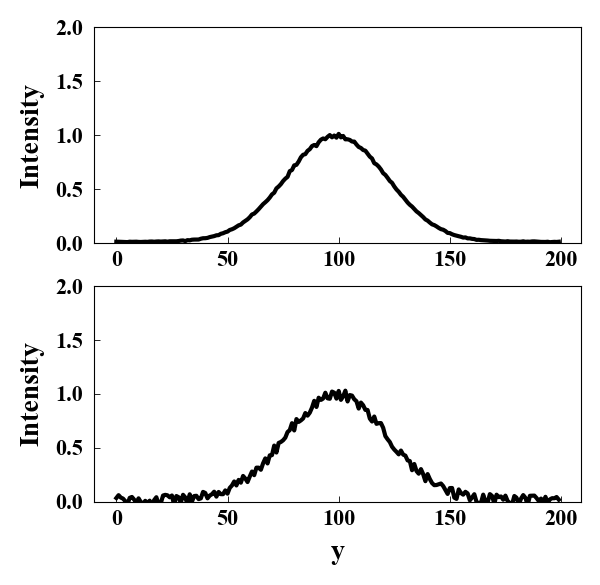

In [14]:
plt.subplot(2,1,1)
plt.plot(x_array, intensity_noise[0],  color="black", label = 'x0 = 0.0')
plt.xlabel('x')          # 軸ラベル
plt.ylabel('Intensity')
plt.ylim(0.0, 2.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(x_array, intensity_noise2[0],  color="black", label = 'x0 = 0.0')
plt.xlabel('y')          # 軸ラベル
plt.ylabel('Intensity')
plt.ylim(0.0, 2.0)
plt.show()
plt.close()

In [16]:
N = test_num #訓練データの個数

#中心位置
idx = np.arange(0.0, 2.1, 0.1).repeat(N/21)
test_t[0] = param[0].repeat(N)
test_t[1] = idx
test_t[2] = param[2].repeat(N)
test_t[3] = param[3].repeat(N)
test_t = test_t.T
idx = idx-1.0
#画像サイズ
size = 100
x_array = np.arange(0, size*2, 1.0)                         # x配列
nx = len(x_array)
intensity = np.zeros((N,nx))
idx = idx + size #中心に持ってくる

99.0
99.1
99.2
99.3
99.4
99.5
99.6
99.7
99.8
99.9
100.0
100.1
100.2
100.3
100.4
100.5
100.6
100.7
100.8
100.9
101.0
(2100, 200)


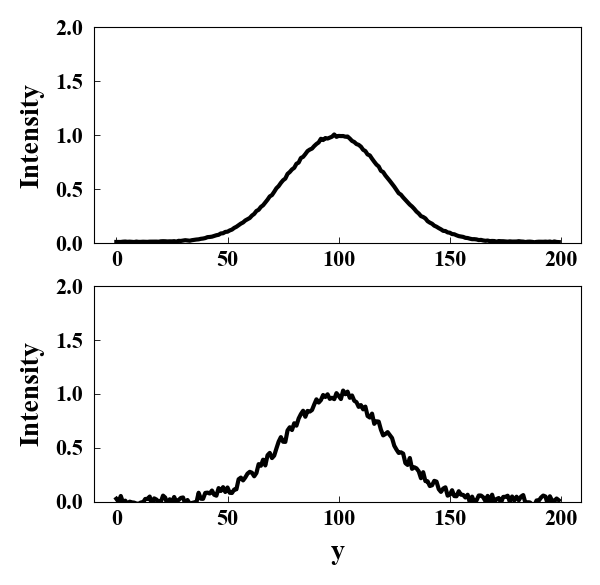

経過時間:0.6152491569519043[sec]


In [20]:
start = time.time()
for n in range(N):
    #初期パラメータ
    i0 = param[0]
    x0 = idx[n]
    w0 = param[2]
    h0 = param[3]
    param = np.array([i0, x0, w0, h0])  #初期値
    
    #強度の計算
    intensity[n] = gaussian_beam(x_array, *param).reshape(nx)
    
intensity_noise = np.zeros((N, nx))
intensity_noise2 = np.zeros((N, nx))
NOISE = np.zeros((N, nx))
noise= np.zeros((N, nx))

for i in range(21):
    profile_i = intensity[int(i*N/21)].flatten()
    print(idx[int(i*N/21)])
    for k in range(nx):
        NOISE[int(i*N/21):int((i+1)*N/21),k] = (np.random.normal(loc=0,scale=0.00844*profile_i[k]+0.00165,size=int(N/21)))
        noise[int(i*N/21):int((i+1)*N/21),k] = (np.random.rand(int(N/21))-0.5)*10*0.01
NOISE = NOISE.reshape(N,nx)
intensity_noise = intensity.reshape(N,nx) + NOISE.reshape(N,nx)
print(noise.shape)
intensity_noise2 = intensity.reshape(N,nx) + noise.reshape(N,nx)

plt.subplot(2,1,1)
plt.plot(x_array, intensity_noise[0],  color="black", label = 'x0 = 0.0')
plt.xlabel('x')          # 軸ラベル
plt.ylabel('Intensity')
plt.ylim(0.0, 2.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(x_array, intensity_noise2[0],  color="black", label = 'x0 = 0.0')
plt.xlabel('y')          # 軸ラベル
plt.ylabel('Intensity')
plt.ylim(0.0, 2.0)
plt.show()
plt.close()

test_x = intensity_noise.reshape(-1, 200)
test_x2 = intensity_noise2.reshape(-1, 200)

elapsed_time = time.time() - start
print ("経過時間:{0}".format(elapsed_time) + "[sec]")

In [21]:
print(intensity.shape)

(2100, 200)


In [23]:
print(test_t.shape)
print(idx.shape)
#data_save

save_name = dt_now.strftime("%Y-%m-%d_%H-%M")+'train_x.pkl'
save_file = os.path.join(save_folder, save_name)
with open(save_file, mode='wb') as f:
    pickle.dump(train_x, f)
print('保存:', save_file)
save_name = dt_now.strftime("%Y-%m-%d_%H-%M")+'train_x2.pkl'
save_file = os.path.join(save_folder, save_name)
with open(save_file, mode='wb') as f:
    pickle.dump(train_x2, f)
print('保存:', save_file)
save_name = dt_now.strftime("%Y-%m-%d_%H-%M")+'train_t.pkl'
save_file = os.path.join(save_folder, save_name)
with open(save_file, mode='wb') as f:
    pickle.dump(train_t, f)
print('保存:', save_file)
save_name = dt_now.strftime("%Y-%m-%d_%H-%M")+'test_x.pkl'
save_file = os.path.join(save_folder, save_name)
with open(save_file, mode='wb') as f:
    pickle.dump(test_x, f)
print('保存:', save_file)
save_name = dt_now.strftime("%Y-%m-%d_%H-%M")+'test_x2.pkl'
save_file = os.path.join(save_folder, save_name)
with open(save_file, mode='wb') as f:
    pickle.dump(test_x2, f)
print('保存:', save_file)
save_name = dt_now.strftime("%Y-%m-%d_%H-%M")+'test_t.pkl'
save_file = os.path.join(save_folder, save_name)
with open(save_file, mode='wb') as f:
    pickle.dump(test_t, f)
print('保存:', save_file)

(2100, 4)
(2100,)
保存: /Users/nagaiyuma/Documents/myprogram/210108/2021-01-08_13-34train_x.pkl
保存: /Users/nagaiyuma/Documents/myprogram/210108/2021-01-08_13-34train_x2.pkl
保存: /Users/nagaiyuma/Documents/myprogram/210108/2021-01-08_13-34train_t.pkl
保存: /Users/nagaiyuma/Documents/myprogram/210108/2021-01-08_13-34test_x.pkl
保存: /Users/nagaiyuma/Documents/myprogram/210108/2021-01-08_13-34test_x2.pkl
保存: /Users/nagaiyuma/Documents/myprogram/210108/2021-01-08_13-34test_t.pkl


In [24]:
#出力1
train_t = train_t.T[2].flatten()
test_t = test_t.T[2].flatten()

In [ ]:
CNN = 'CNN(出力1)'
batch_size = 200  # 訓練データを128ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

model = Sequential()
model.add(Conv1D(10, 3, padding='same', input_shape=(200, 1), activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(20, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(layers.Flatten())
model.add(Dense(200,activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu', kernel_initializer="he_normal", bias_intializer=kernel_initializer.Constant(value=90)))

model.summary()

In [ ]:
CNN = 'NN(出力1)'
batch_size = 200  # 訓練データを128ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

model = Sequential()
model.add(Dense(200,activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu', kernel_initializer="he_normal"))

model.summary()

In [56]:
train_x = train_x.reshape(-1, 200,1)
test_x = test_x.reshape(-1, 200,1)

train_x2 = train_x2.reshape(-1, 200,1)
test_x2 = test_x2.reshape(-1, 200,1)

In [ ]:
CNN = CNN+'norm'

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
CNN = CNN+'uni'
model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

callbacks = [keras.callbacks.TensorBoard(log_dir='./logs',
                            histogram_freq=1, 
                            batch_size=batch_size, 
                            write_graph=True, 
                            write_grads=True)]

history = model.fit(train_x2, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x2, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [74]:
dt_now = datetime.datetime.now()
print('現在時刻：', dt_now)

#modelの保存
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +f'_{CNN}_model.h5'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
model.save(save_file)
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

現在時刻： 2020-12-12 19:33:45.699084
保存ファイル名： 2020-12-12_19-33_CNN(出力1, Sigmoid)rand_model.h5
保存ファイルパス： /home/kataoka/nagai/201212/Learnings/2020-12-12_19-33_CNN(出力1, Sigmoid)rand_model.h5


In [75]:
#historyの保存
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
save_data = np.array((epochs, mae, val_mae, loss, val_loss))
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +f'_{CNN}_history.json'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
hist_df = pd.DataFrame(history.history) 
with open(save_file, mode='w') as f:
    hist_df.to_json(f)
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

保存ファイル名： 2020-12-12_19-33_CNN(出力1, Sigmoid)rand_history.json
保存ファイルパス： /home/kataoka/nagai/201212/Learnings/2020-12-12_19-33_CNN(出力1, Sigmoid)rand_history.json


/home/kataoka/miniconda3/envs/ura/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
/home/kataoka/miniconda3/envs/ura/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


保存ファイル名： 2020-12-12_19-33_CNN(出力1, Sigmoid)rand_loss.png
保存ファイルパス： /home/kataoka/nagai/201212/Learnings/2020-12-12_19-33_CNN(出力1, Sigmoid)rand_loss.png
保存ファイル名： 2020-12-12_19-33_CNN(出力1, Sigmoid)rand_mae.png
保存ファイルパス： /home/kataoka/nagai/201212/Learnings/2020-12-12_19-33_CNN(出力1, Sigmoid)rand_mae.png


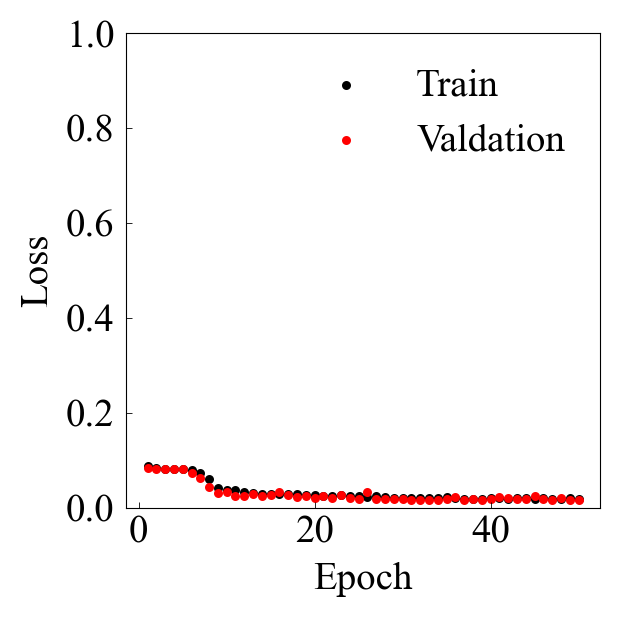

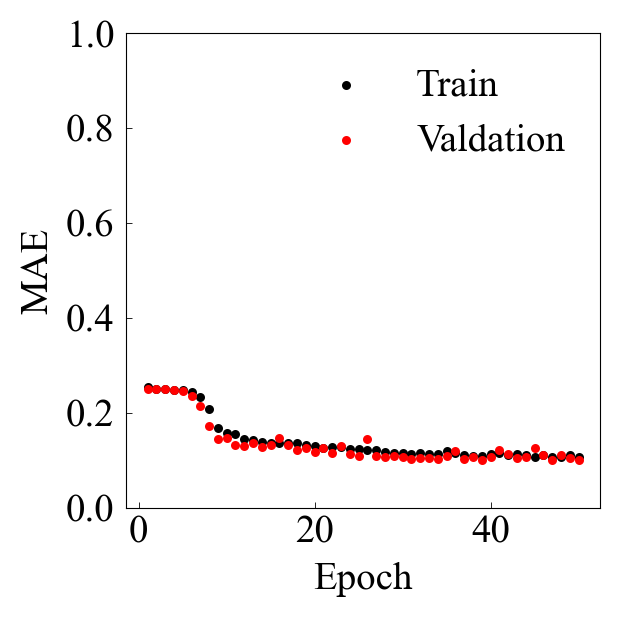

In [76]:
#損失関数の推移
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +f'_{CNN}_loss.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(epochs, loss,  color="black", label = 'Train', s=5)
ax.scatter(epochs, val_loss,  color="red", label = 'Valdation', s=5)
ax.legend(frameon=False)
ax.set_xlabel('Epoch',fontsize=14)          # 軸ラベル
ax.set_ylabel('Loss',fontsize=14)
ax.set_ylim(0, 1.0)      # y軸の表示範囲
plt.tick_params(labelsize=14)
ax.set_aspect(1./ax.get_data_ratio()) # グラフを正方形にする
fig.savefig(save_file, format="png", bbox_inches="tight")
fig.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

#maeの推移
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +f'_{CNN}_mae.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(epochs, mae,  color="black", label = 'Train',s=5)
ax.scatter(epochs, val_mae,  color="red", label = 'Valdation', s=5)
ax.legend(frameon=False)
ax.set_xlabel('Epoch',fontsize=14)          # 軸ラベル
ax.set_ylabel('MAE',fontsize=14)
ax.set_ylim(0, 1.0)      # y軸の表示範囲
plt.tick_params(labelsize=14)
ax.set_aspect(1./ax.get_data_ratio()) # グラフを正方形にする
fig.savefig(save_file, format="png", bbox_inches="tight")
fig.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)